# Pipeline score mathcing

The pipeline which enable us to get a similarity score between the target captions sentence and one of the boxes found by detr. Here, we do not use contextual relationships in between the objects in the image. The model rely on informations in the texual description of the objects given by clip and try to match them with the one in the target caption. We tried to scoring to find the best match approaching the problem with different strategies.

However, we suppose that using model which capture a contextual graph of the objects in the image we can improve the effectiveness of the model.

In [1]:
# load the refCOCOg dataset
!pip install gdown
import gdown

url = "https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq"
gdown.download(url)

!tar -xvf /content/refcocog.tar.gz

!rm /content/refcocog.tar.gz

import pickle
import numpy as np
import json
import matplotlib.pyplot as plt
import os

from PIL import Image

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  annotations = pickle.load(fp)

  train_data = sorted([d for d in annotations if d["split"]=="train"], key=lambda d: d["file_name"])
  val_data = sorted([d for d in annotations if d["split"]=="val"], key=lambda d: d["image_id"])
  test_data = sorted([d for d in annotations if d["split"]=="test"], key=lambda d: d["image_id"])


  # image_ids = []
  # for d in train_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")
    
  # for d in val_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")
  
  # for d in test_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")

  # print(len([d for d in train_data if d["image_id"]==9]))

  entry = train_data[0]

  print(json.dumps(entry, indent=4, default=str))

  # img = Image.open(entry["file_name"])

  # plt.title(entry["sentences"][0]["raw"])
  # plt.imshow(img)
  # plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100%|██████████| 13.5G/13.5G [05:22<00:00, 41.8MB/s]


Streaming output truncated to the last 5000 lines.
./refcocog/images/COCO_train2014_000000419396.jpg
./refcocog/images/COCO_train2014_000000433336.jpg
./refcocog/images/COCO_train2014_000000567523.jpg
./refcocog/images/COCO_train2014_000000451554.jpg
./refcocog/images/COCO_train2014_000000439855.jpg
./refcocog/images/COCO_train2014_000000044594.jpg
./refcocog/images/COCO_train2014_000000194276.jpg
./refcocog/images/COCO_train2014_000000272463.jpg
./refcocog/images/COCO_train2014_000000485426.jpg
./refcocog/images/COCO_train2014_000000002774.jpg
./refcocog/images/COCO_train2014_000000346160.jpg
./refcocog/images/COCO_train2014_000000199829.jpg
./refcocog/images/COCO_train2014_000000210057.jpg
./refcocog/images/COCO_train2014_000000544117.jpg
./refcocog/images/COCO_train2014_000000440673.jpg
./refcocog/images/COCO_train2014_000000006151.jpg
./refcocog/images/COCO_train2014_000000514391.jpg
./refcocog/images/COCO_train2014_000000247459.jpg
./refcocog/images/COCO_train2014_000000141257.jpg

In [2]:
# print(json.dumps(test_data[0], indent=4, default=str))

from copy import deepcopy

d = deepcopy(test_data[0])

d["file_name"] = f'{"_".join(d["file_name"].split("_")[:3])}.jpg'

print(d["file_name"])

with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  print(data.keys())

  print(data["images"][0])

  t = sorted([d for d in data["annotations"]], key=lambda x: x["image_id"])

  print([d["image_id"] for d in t[:10]])

  for e in data["annotations"]:
    if e["id"]>=1000000 and e["id"]<1040000: #1038967
      print("BBOX = ",json.dumps(e["id"], indent=4))
      break

COCO_train2014_000000000656.jpg
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])
{'license': 1, 'file_name': 'COCO_train2014_000000131074.jpg', 'coco_url': 'http://mscoco.org/images/131074', 'height': 428, 'width': 640, 'date_captured': '2013-11-21 01:03:06', 'flickr_url': 'http://farm9.staticflickr.com/8308/7908210548_33e532d119_z.jpg', 'id': 131074}
[9, 9, 9, 9, 9, 9, 9, 9, 25, 25]
BBOX =  1038967


In [3]:
import os
import json

from torch.utils.data import Dataset

class RefCOCOg(Dataset):
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [4]:
# Load refs and annotations
import pickle

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [5]:
train_dataset = RefCOCOg(refs=refs, annotations=annotations, split="train")

print(train_dataset[0])
print(train_dataset)
print(len(train_dataset))
train_dataset(0)

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
42226
{
    "file_name": "./refcocog/images/COCO_train2014_000000519404.jpg",
    "caption": "Two woman one in black eatting and the other has a white shirt at the desk",
    "ann_id": 1241542,
    "bbox": [
        0.0,
        45.95,
        238.92,
        408.64
    ]
}


In [6]:
# source: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=Y6Jrz6xz71C0
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [7]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    

# here we show the evindece of how much detr is precise 
# compared to yolo

In [8]:
import matplotlib.pyplot as plt

def bring_crop(f_name, box, display = False):

  x_min, y_min, x_max, y_max = box.tolist()

  if display:
    # plot the box
    plt.figure()
    plt.imshow(plt.imread(f_name)[int(y_min):int(y_max),int(x_min):int(x_max)])
    plt.title('Target box')
    plt.axis('off')
    return None
  
  return plt.imread(f_name)[int(y_min):int(y_max),int(x_min):int(x_max)]

In [ ]:
# install clip dependencies
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-djhrm9x2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-djhrm9x2
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


### Install the salesforce-lavis library

With that library we can perform the

In [9]:
!pip install salesforce-lavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 26.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
import numpy as np

In [ ]:
import gc
gc.collect()

884

Try to replicate the experiments using a different image

In [20]:
# load the models
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
import numpy as np
import clip
from PIL import Image


# check if gpu available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_grad_enabled(False);

def get_detr_model():
    return torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)


detr = get_detr_model()
detr.eval()


# load the blip model
# large_model -> better performance 
# blip, vis_processors, _ = load_model_and_preprocess(
#     name="blip_caption", model_type="base_coco", is_eval=True, device=device
# )

# clip, preprocess = clip.load("ViT-B/32", device=device)
m_clip, preprocess = clip.load("RN50", device=device)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

vis_processors = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

Target caption:  A woman in a flowered shirt.


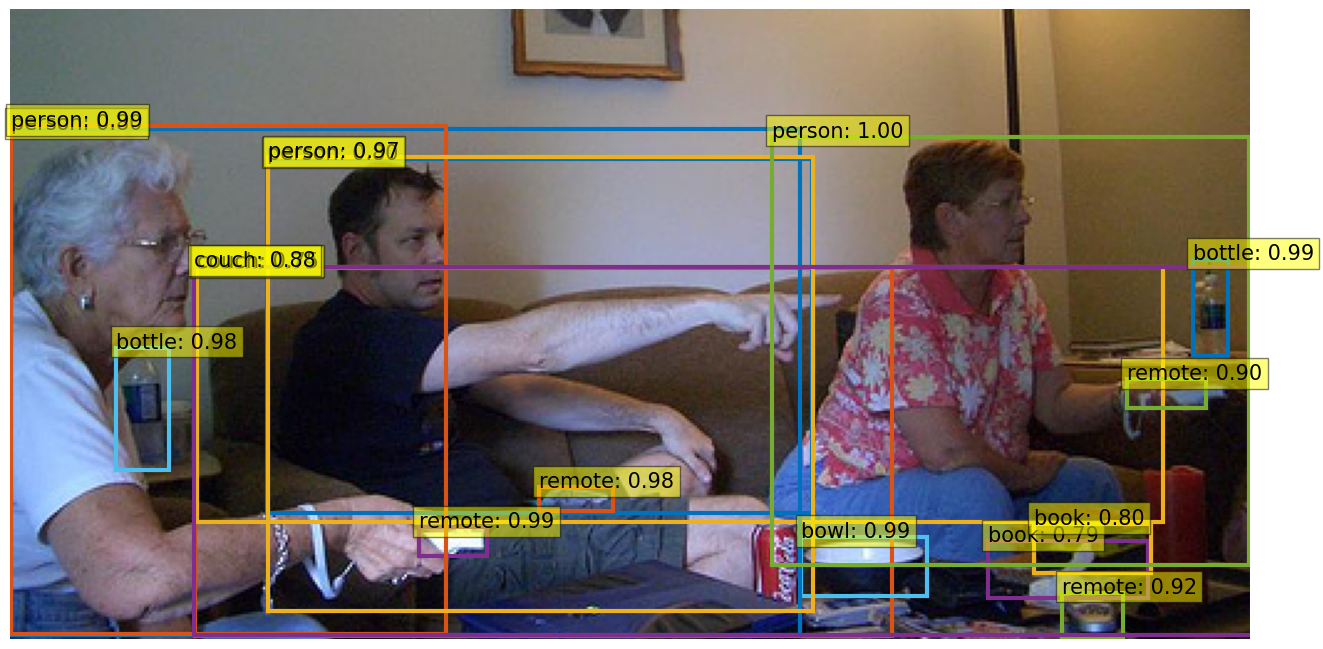

number of boxes found:  17


In [95]:
import torch


def caption_clip_encoding(caption_detr_boxes, target_caption):

  encoding_text_features = []

  text = clip.tokenize(target_caption).to(device)
  text_features = model.encode_text(text)
  encoding_text_features.append(text_features)

  for i in caption_detr_boxes:
    temp = []
    for j in i:
      text = clip.tokenize(j).to(device)
      with torch.no_grad():
        text_features = m_clip.encode_text(text)
      
      temp.append(text_features)

    encoding_text_features.append(temp)

  return encoding_text_features

def euclidean_distance(u, v):
    """Computes the euclidean distance between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: euclidean distance between the two sets of items
    """
    return torch.sqrt(torch.sum((u - v) ** 2))

def get_image(f_name):
    return Image.open(f_name)

def load_image(image):
    return Image.fromarray(np.uint8(image)).convert('RGB')  


def pipeline(t_data,ten_caption = False):

    f_name = t_data['file_name']
    im = get_image(f_name)

    scores, boxes = detect(im, detr, transform)

    # plot the image with the boxes
    print('Target caption: ', t_data['caption'])
    plot_results(im, scores, boxes)

    # boxes found by detr
    boxes_found_detr = [bring_crop(f_name, b, display = False) for b in boxes]
    print('number of boxes found: ',len(boxes_found_detr))

    # convert array to pillow image
    im_detr_boxes = [load_image(i) for i in boxes_found_detr]

    # preprocess the boxes
    # images_preprocessed = [vis_processors["eval"](i).unsqueeze(0).to("cuda", torch.float16) for i in im_detr_boxes]
    images_preprocessed = [vis_processors(i, return_tensors="pt").to("cuda", torch.float16) for i in im_detr_boxes]
    

    # generate 10 caption or only one for each box
    if ten_caption == True:
      # caption_detr_boxes = [blip.generate({"image": i}, use_nucleus_sampling=True, num_captions=10) for i in images_preprocessed]
      caption_detr_boxes = [vis_processors.decode(blip.generate(**i)[0], use_nucleus_sampling=True, num_captions=10, skip_special_tokens=True) for i in images_preprocessed]
    else:
      # caption_detr_boxes = [blip.generate({"image": i}) for i in images_preprocessed]
      caption_detr_boxes = [vis_processors.decode(blip.generate(**i)[0], skip_special_tokens=True) for i in images_preprocessed]

    # convert array boxes to PILLOW image
    IMG_boxes_found_detr = [Image.fromarray(box) for box in boxes_found_detr]

    # preprocess with clip

    # compute the score caption - target image

    image = preprocess(im).unsqueeze(0).to(device)

    probabilities = []
    euclidean_text_features = []
    for b in caption_detr_boxes:
      sent = []
      sent.append(t_data['caption'])

      if ten_caption == True:
        for i in b:
          sent.append(i)
      else:
        sent.append(b)

      text = clip.tokenize(sent).to(device)

      # Compute logits
      with torch.no_grad():
          image_features = m_clip.encode_image(image)
          text_features = m_clip.encode_text(text)
          
          logits_per_image, logits_per_text = m_clip(image, text)
          probs = logits_per_image.softmax(dim=-1).cpu().numpy()

      probabilities.append(probs)

    if ten_caption == True:

      eucludean = []
      for j in text_features[1:]:
          euclidean.append(float(euclidean_distance(text_features[0].reshape(512),j.reshape(512))))

      euclidean_text_features.append(euclidean)

    else:
      sent = []
      sent.append(t_data['caption'])
      for b in caption_detr_boxes:
        sent.append(b)

      text = clip.tokenize(sent).to(device)
      with torch.no_grad():
          text_features = m_clip.encode_text(text)

      for b in text_features[1:]:
        euclidean_text_features.append(float(euclidean_distance(text_features[0].reshape(1024),b.reshape(1024))))

      

    # compute the score caption - target image
    encoding_text_features = []

    sent = []
    sent.append(t_data['caption'])
    text = clip.tokenize(sent).to(device)

    image = torch.Tensor(np.stack([preprocess(imm) for imm in IMG_boxes_found_detr])).to(device)

    # Compute logits
    with torch.no_grad():
        image_features = m_clip.encode_image(image)
        text_features = m_clip.encode_text(text)
        
        logits_per_image, logits_per_text = m_clip(image, text)
        # probs_box_cap = logits_per_image.softmax(dim=-1).cpu().numpy()
        probs_box_cap = logits_per_image.cpu().numpy()

    return probs_box_cap, euclidean_text_features, probabilities, caption_detr_boxes,t_data['caption'], IMG_boxes_found_detr, im


probs_box_cap, euclidean_text_features, probabilities, caption_detr_boxes, target_caption, IMG_boxes_found_detr, im = pipeline(train_dataset[10])

In [96]:
euclidean_text_features

[9.3515625,
 9.171875,
 10.0,
 10.21875,
 9.7890625,
 9.6171875,
 9.65625,
 8.1328125,
 9.5625,
 10.0,
 9.1171875,
 8.75,
 9.7421875,
 9.5078125,
 9.171875,
 10.0,
 8.6328125]

16


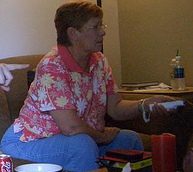

In [90]:
idx = np.argmax(probs_box_cap)
print(idx)
IMG_boxes_found_detr[idx]

In [52]:
caption_detr_boxes

['a man and a baby sitting on a couch',
 'a man sitting on a couch',
 'a group of people sitting on a couch playing a video game',
 'a white dove in the middle of a tree',
 'a blur of a car in the dark',
 'a white bowl sitting on top of a table',
 'a blur of a car driving on a road',
 'a man in a white shirt and tie',
 'a white bird is flying in the air',
 'a white triangle with a black background',
 'a blury image of a man in a suit',
 'a man in a white shirt is holding a cell',
 'a group of people sitting on a couch',
 'a man and woman playing a video game',
 'a man sitting on a couch',
 'a group of people sitting on a couch playing a video game',
 'a woman sitting on a couch']

In [97]:
print('target caption: ', target_caption)

# i compute the distance between the probabilities of the 
# matching image text ... I sum one to pick the maximum

print(1+np.array(probabilities).squeeze(1)[:,0]-np.array(probabilities).squeeze(1)[:,1])

# convert array boxes to PILLOW image
# IMG_boxes_found_detr = [Image.fromarray(box) for box in boxes_found_detr]

norm_prob = 1 + np.array(probabilities).squeeze(1)[:,0] - np.array(probabilities).squeeze(1)[:,1]

idx = np.argmax(norm_prob)

IMG_boxes_found_detr[idx]

target caption:  A woman in a flowered shirt.
[0.0664  0.0249  0.      2.      2.      1.948   2.      1.869   1.989
 1.972   1.842   0.9688  0.00928 0.      0.0249  0.      0.06494]


[9.3515625, 9.171875, 10.0, 10.21875, 9.7890625, 9.6171875, 9.65625, 8.1328125, 9.5625, 10.0, 9.1171875, 8.75, 9.7421875, 9.5078125, 9.171875, 10.0, 8.6328125]
16


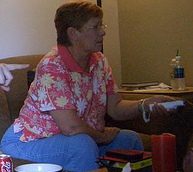

In [123]:
idx = np.argmin(euclidean_text_features)
print(euclidean_text_features)
IMG_boxes_found_detr[idx+1]

temp = np.delete(euclidean_text_features,idx)
idx = np.argmin(temp)+1
print(len(temp))
IMG_boxes_found_detr[idx]

In [85]:
probabilities

[]